In [3]:
import pandas as pd
import numpy as np
import nltk
import pickle
import re
import matplotlib.pyplot as plt
import seaborn as sns

from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
from keras.models import Sequential, load_model
from keras.layers import Dense, Embedding, Conv1D, GlobalMaxPooling1D, Dropout
from keras.utils import pad_sequences
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from sklearn.preprocessing import LabelEncoder

In [4]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [5]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [13]:
# Set the maximum number of words to keep based on word frequency
from sklearn.utils import resample


max_words = 10000

# Set random seed for reproducibility
np.random.seed(42)

# Load the data from the CSV file
df = pd.read_csv('/content/datasetEN.csv')

# Separate the data into positive, negative, and neutral examples
positive_examples = df[df['sentiment'] == 'positive']
negative_examples = df[df['sentiment'] == 'negative']
neutral_examples = df[df['sentiment'] == 'neutral']

# Resample the examples to the desired number
pos = 25000
neg = 25000
neu = 18000
positive_examples = resample(positive_examples, n_samples=pos, random_state=42)
negative_examples = resample(negative_examples, n_samples=neg, random_state=42)
neutral_examples = resample(neutral_examples, n_samples=neu, random_state=42)

# Concatenate the resampled examples back into a single DataFrame
df_resampled = pd.concat([positive_examples, negative_examples, neutral_examples])


# Preprocess the text
def preprocess_text(text):
    # Check if text is not null
    if isinstance(text, str):
        # Remove special characters and convert to lowercase
        text = re.sub(r"[^a-zA-Z0-9]", " ", text.lower())
        # Tokenize the text
        tokens = nltk.word_tokenize(text)
        # Remove stopwords
        stop_words = set(stopwords.words('english'))
        tokens = [token for token in tokens if token not in stop_words]
        # Join tokens back into a string
        text = " ".join(tokens)
    return text

# Apply preprocessing to the text column
df_resampled['text'] = df_resampled['text'].apply(preprocess_text)

# Remove rows with null values in 'text' column
df_resampled = df_resampled.dropna(subset=['text'])

# Split the data into text and labels
x = df_resampled['text'].values
y = df_resampled['sentiment'].values

# Convert the labels using LabelEncoder
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Split the data into training and test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Convert the labels to one-hot encoded vectors
num_classes = len(label_encoder.classes_)
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

# Tokenize the text
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(x_train)
x_train = tokenizer.texts_to_sequences(x_train)
x_test = tokenizer.texts_to_sequences(x_test)

# Get the maximum sequence length
maxlen = max(len(x) for x in x_train)
print('maxlen:', maxlen)
# Pad sequences to have the same length
x_train = pad_sequences(x_train, maxlen=maxlen)
x_test = pad_sequences(x_test, maxlen=maxlen)

maxlen: 52


In [12]:
df

,text,sentiment
0,I love this product!,positive
1,pen,neutral
2,This movie is terrible.,negative
3,The food at this restaurant was amazing!,positive
4,I was really disappointed with the service.,negative
...,...,...
58902,i could totally do without but i feel like it ...,positive
58903,i eat i do feel more selfish like i am not thi...,negative
58904,i didn t feel groggy necessarily but still fel...,negative
58905,i paint feels like a spark of the divine meeti...,positive


Train
positive    25000
negative    25000
neutral     18000
Name: sentiment, dtype: int64 

Test
Count y_test positive: 5076
Count y_test negative: 3562
Count y_test neutral: 4962


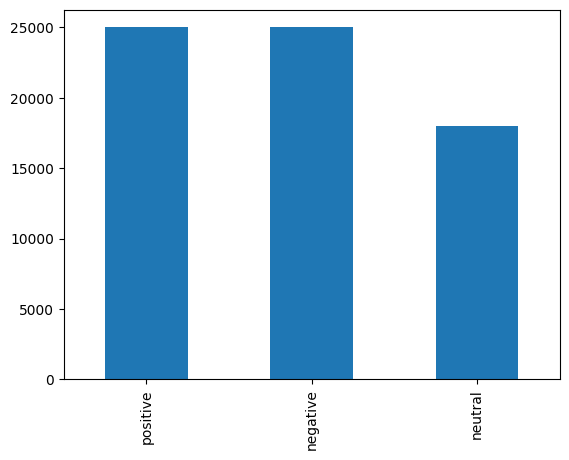

In [9]:
df_resampled['sentiment'].value_counts().plot.bar()
print("Train")
print(df_resampled['sentiment'].value_counts(),"\n")

# Decode the labels from one-hot encoded vectors to sentiment labels
labels = np.argmax(y_test, axis=1)
label_counts = np.bincount(labels)

# Create a dictionary to map label indices to their corresponding labels
label_mapping = {0: 'positive', 1: 'negative', 2: 'neutral'}

print("Test")
# Print the label counts
for label_idx, count in enumerate(label_counts):
    label = label_mapping[label_idx]
    print(f"Count y_test {label}: {count}")

In [11]:
set(df['sentiment'])

{nan, 'negative', 'neutral', 'positive'}

In [ ]:
# Define the model
model = Sequential()
model.add(Embedding(max_words, 128, input_length=maxlen))
model.add(Conv1D(128, 5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(set(df['sentiment'])), activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 129, 128)          1280000   
                                                                 
 conv1d_1 (Conv1D)           (None, 125, 128)          82048     
                                                                 
 global_max_pooling1d_1 (Gl  (None, 128)               0         
 obalMaxPooling1D)                                               
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 3)                 195       
                                                      

In [ ]:
# Define callbacks
filename = 'sentiment_analysis_modelEN.h5'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience=3, verbose=1, factor=0.1, min_lr=0.000001)
callbacks = [checkpoint, learning_rate_reduction]

# Train the model
history = model.fit(x_train, y_train, epochs=5, batch_size=64, validation_data=(x_test, y_test), callbacks=callbacks)

Epoch 1/5
847/847 [==============================] - ETA: 0s - loss: 0.3481 - accuracy: 0.8518
Epoch 1: val_loss improved from inf to 0.17753, saving model to sentiment_analysis_modelEN.h5
847/847 [==============================] - 110s 128ms/step - loss: 0.3481 - accuracy: 0.8518 - val_loss: 0.1775 - val_accuracy: 0.9340 - lr: 0.0010
Epoch 2/5
  1/847 [..............................] - ETA: 1:24 - loss: 0.0907 - accuracy: 0.9844

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


847/847 [==============================] - ETA: 0s - loss: 0.1269 - accuracy: 0.9567
Epoch 2: val_loss improved from 0.17753 to 0.15127, saving model to sentiment_analysis_modelEN.h5
847/847 [==============================] - 104s 123ms/step - loss: 0.1269 - accuracy: 0.9567 - val_loss: 0.1513 - val_accuracy: 0.9462 - lr: 0.0010
Epoch 3/5
847/847 [==============================] - ETA: 0s - loss: 0.0668 - accuracy: 0.9774
Epoch 3: val_loss did not improve from 0.15127
847/847 [==============================] - 104s 123ms/step - loss: 0.0668 - accuracy: 0.9774 - val_loss: 0.1598 - val_accuracy: 0.9501 - lr: 0.0010
Epoch 4/5
847/847 [==============================] - ETA: 0s - loss: 0.0410 - accuracy: 0.9862
Epoch 4: val_loss did not improve from 0.15127
847/847 [==============================] - 107s 126ms/step - loss: 0.0410 - accuracy: 0.9862 - val_loss: 0.2007 - val_accuracy: 0.9518 - lr: 0.0010
Epoch 5/5
847/847 [==============================] - ETA: 0s - loss: 0.0333 - accuracy: 0

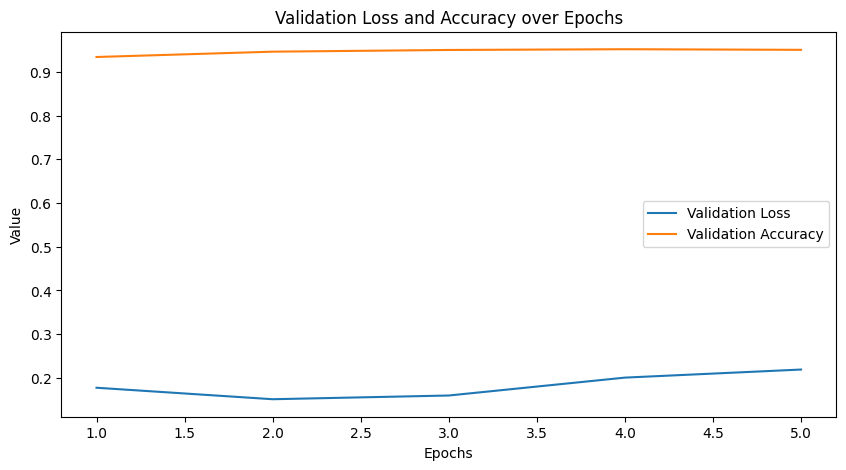

In [ ]:
# Get the epoch numbers
epochs = range(1, len(history.history['val_loss']) + 1)

# Plot validation loss and accuracy
plt.figure(figsize=(10, 5))
plt.plot(epochs, history.history['val_loss'], label='Validation Loss')
plt.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.title('Validation Loss and Accuracy over Epochs')
plt.legend()
plt.show()

Test Loss: 0.15127423405647278
Test Accuracy: 0.9461953043937683
424/424 [==============================] - 8s 18ms/step
Class: negative
Precision: 0.9596709470304976
Recall: 0.9437647987371744
F1-score: 0.9516514126541982

Class: neutral
Precision: 0.8974759302628155
Recall: 0.9753959276018099
F1-score: 0.9348150155847674

Class: positive
Precision: 0.9716221939855993
Recall: 0.9278058645096057
F1-score: 0.9492086479776559



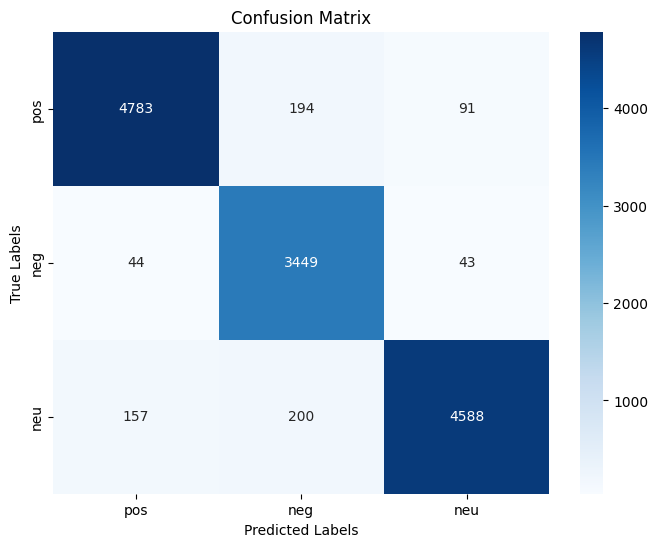

In [ ]:
# Load the best model
model = load_model(filename)

# Evaluate the model
loss, accuracy = model.evaluate(x_test, y_test, verbose=0)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

# Predict classes for test data
y_pred = model.predict(x_test)
predicted_classes = np.argmax(y_pred, axis=1)

# Define class labels
class_labels = ['pos', 'neg', 'neu']

# Compute confusion matrix
confusion_mat = confusion_matrix(np.argmax(y_test, axis=1), predicted_classes)

# Calculate precision, recall, and F1-score
precision = precision_score(np.argmax(y_test, axis=1), predicted_classes, average=None)
recall = recall_score(np.argmax(y_test, axis=1), predicted_classes, average=None)
f1 = f1_score(np.argmax(y_test, axis=1), predicted_classes, average=None)

# Print precision, recall, and F1-score for each class
for i, label in enumerate(set(df['sentiment'])):
    print(f"Class: {label}")
    print("Precision:", precision[i])
    print("Recall:", recall[i])
    print("F1-score:", f1[i])
    print()

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Save the trained model and the tokenizer to disk
model.save('sentiment_analysis_modelEN.h5')
with open('tokenizerEN.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
